In [1]:
import numpy as np 
import pandas as pd 

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_palette('Set2')
import matplotlib.pyplot as plt
%matplotlib inline

# Supress Scientific notation in python
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display all columns of long dataframe
pd.set_option('display.max_columns', None)

import re

from math import sqrt 
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb
from sklearn.model_selection import KFold

import pandas_profiling

In [2]:
# Import datasets
train = pd.read_excel('../input/Data_Train.xlsx')
test = pd.read_excel('../input/Data_Test.xlsx')

In [3]:
# Checkout the shape of datasets
train.shape, test.shape

((6019, 13), (1234, 12))

Let's have a look at the different aspects of the dataset through amazing pandas profiling tool

In [4]:
train.profile_report()

In [5]:
train.sample(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
5324,Hyundai Grand i10 1.2 CRDi Sportz,Delhi,2015,59261,Diesel,Manual,First,24.0 kmpl,1186 CC,73.97 bhp,5.00,8.18 Lakh,4.25
4261,Audi A6 2011-2015 2.0 TDI Premium Plus,Mumbai,2013,56500,Diesel,Automatic,First,17.68 kmpl,1968 CC,174.33 bhp,5.00,NaN,19.80
4856,BMW X3 xDrive20d xLine,Kochi,2017,41816,Diesel,Automatic,First,18.56 kmpl,1995 CC,190 bhp,5.00,NaN,32.78
4934,Maruti Dzire AMT VDI,Coimbatore,2018,25082,Diesel,Automatic,First,28.4 kmpl,1248 CC,73.75 bhp,5.00,9.62 Lakh,8.37
4636,Maruti SX4 Zxi BSIII,Mumbai,2009,63274,Petrol,Manual,Second,15.0 kmpl,1586 CC,104.68 bhp,5.00,NaN,1.99


In [6]:
test.sample(5)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
1011,Mercedes-Benz E-Class E250 CDI Launch Edition,Delhi,2013,35000,Diesel,Automatic,First,13.0 kmpl,2143 CC,204 bhp,5.00,NaN
1202,Honda City i-VTEC VX,Coimbatore,2018,31542,Petrol,Manual,First,17.4 kmpl,1497 CC,117.3 bhp,5.00,12.68 Lakh
692,Maruti Swift VXI BSIV,Pune,2014,85000,Petrol,Manual,First,20.4 kmpl,1197 CC,81.80 bhp,5.00,NaN
1220,Honda Amaze VX AT i-Vtech,Hyderabad,2014,57000,Petrol,Automatic,First,15.5 kmpl,1198 CC,86.7 bhp,5.00,NaN
608,Toyota Corolla Altis G,Mumbai,2009,48233,Petrol,Manual,First,14.53 kmpl,1798 CC,138.1 bhp,5.00,NaN


In [7]:
# Define categorical features
categorical_feature = ['Name','Location','Fuel_Type','Transmission','Owner_Type']

In [8]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"+"There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
New_Price,5195,86.30
Seats,42,0.70
Engine,36,0.60
Power,36,0.60
Mileage,2,0.00


In [10]:
missing_values_table(test)

Your selected dataframe has 12 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
New_Price,1052,85.30
Seats,11,0.90
Engine,10,0.80
Power,10,0.80


In [11]:
train[categorical_feature].nunique()

Name            1876
Location          11
Fuel_Type          5
Transmission       2
Owner_Type         4
dtype: int64

In [12]:
test[categorical_feature].nunique()

Name            768
Location         11
Fuel_Type         4
Transmission      2
Owner_Type        4
dtype: int64

Clear difference in the uniqueness of **Name** and **Fuel_type** feature. Lets check and remove the redundant records from the training set

In [13]:
# Check the Fuel_Type which is not in test set
list(train.Fuel_Type[~train.Fuel_Type.isin(test.Fuel_Type)].unique())

['Electric']

There are **no** Electric vehicles in the **Test** set. Hence remove the rows from training set where **Fuel_type** is **Electric**

In [14]:
train = train[train.Fuel_Type != 'Electric']

Coming to Names column, Lets check the naming pattern of different cars in the Dataset

In [15]:
train["Full_name"] = train.Name.copy()
test["Full_name"] = test.Name.copy()
train.Name.sample(20)

1084          Volkswagen Ameo 1.2 MPI Comfortline
1104         Audi Q7 3.0 TDI Quattro Premium Plus
5445                         Toyota Camry W2 (AT)
5583                         Volvo XC60 D4 SUMMUM
999     Nissan Sunny 2011-2014 XV Special Edition
3223                            Maruti A-Star Vxi
3724             Mercedes-Benz M-Class ML 320 CDI
5246                           Tata Indica V2 eLX
5397                 Mini Cooper S Carbon Edition
2525                     Maruti Wagon R LXI BSIII
4010                            Maruti A-Star Vxi
2312              Chevrolet Tavera LT 9 Str BS IV
1901                Mahindra Ssangyong Rexton RX7
3922                  Hyundai Santro Xing GL Plus
554                Honda Civic 2006-2010 1.8 S MT
2928                   Jaguar XF 2.2 Litre Luxury
142                          Maruti Swift VVT VXI
5106                              Maruti Ritz VXi
4909         Chevrolet Optra Magnum 1.6 LS Petrol
2985                 Ford EcoSport 1.5 TDCi Trend


Crazy naming convention. Lets find unique car brands in the train set which are **not** in test set

In [16]:
temp1 = list(train.Name.str.split(' ').str[0].unique())
temp2 = list(test.Name.str.split(' ').str[0].unique())
temp3 = [item for item in temp1 if item not in temp2]
temp3

['Smart', 'Ambassador', 'Force', 'Lamborghini']

lets remove the records which contains these brands from the train set first

In [17]:
train = train[~train.Name.str.contains('|'.join(temp3))]

Lets remove the year content in the names

In [18]:
def remove_year(data):
    result = re.search("([0-9]+[-]+[0-9]+)",data)
    if result:
        arr = data.replace(result.group(1),"")
        return arr
    else:
        return data

In [19]:
train.Name = train.Name.apply(lambda x: remove_year(x))
test.Name = test.Name.apply(lambda x: remove_year(x))

Let's remove special characters like **[- . /()]** etc

In [20]:
def remove_char(str):
    arr = ' '.join(str.split()) #replace multiple spaces to single space
    arr = re.sub(r"[-(){}<>/\.,]","", arr) #remove special characters
    return arr.lower() #lowercase all characters

In [21]:
train.Full_name = train.Name.apply(lambda x: remove_char(x))
test.Full_name = test.Name.apply(lambda x: remove_char(x))

Lets keep only the **first two relevant words** in the car names and remove the rest to be consistent across the dataset

In [22]:
train.Name = train.Full_name.apply(lambda x: " ".join(x.split(' ')[:2]))
test.Name = test.Full_name.apply(lambda x: " ".join(x.split(' ')[:2]))

# Filter brand name for a more generic aggregation in further calculations
train['brand'] = train.Name.apply(lambda x: " ".join(x.split(' ')[:1]))
test['brand'] = test.Name.apply(lambda x: " ".join(x.split(' ')[:1]))


Let's have a look at the car names after processing

In [23]:
train.Name.sample(10)

4679             honda city
4288             honda city
2072                audi a6
1537                audi q5
5208            skoda rapid
1580            hyundai i10
2509    mercedesbenz eclass
2871       volkswagen vento
4900         hyundai santro
1465            maruti ritz
Name: Name, dtype: object

Moving on to the other metrics, we will correct the feature values as per below strategy 

* Remove the New_price currency unit from each value and convert into relevant amount
* Remove the Engine capacity unit from each value
* Remove the Mileage unit and comvert all "0.0 kmpl" value to NaN
* Remove the units of Power and convert "null bhp" to NaN

 After all this filtering, we will fill the missing values with the mean or median value respective to each feature

In [24]:
# Define function to correct the New_Price value
def price_correct(x):
    if str(x).endswith('Lakh'):
        return float(str(x).split()[0])*100000
    elif str(x).endswith('Cr'):
        return float(str(x).split()[0])*10000000
    else:
        return x

train.New_Price = train.New_Price.apply(price_correct)
test.New_Price = test.New_Price.apply(price_correct)

In [25]:
train.Mileage = train.Mileage.replace('0.0 kmpl', np.NaN).apply(lambda x: str(x).split()[0]).astype(float).round(2) # Convert 0 value to Nan, remove unit and convert to float type and round off to 2 decimal place.
train.Engine = train.Engine.apply(lambda x: str(x).split()[0]).astype(float) # Remove the CC part
train.Power = train.Power.replace('null bhp', np.NaN).apply(lambda x: str(x).split()[0]).astype(float).round(2) # convert null value to NaN than as above

test.Mileage = test.Mileage.replace('0.0 kmpl', np.NaN).apply(lambda x: str(x).split()[0]).astype(float).round(2)
test.Engine = test.Engine.apply(lambda x: str(x).split()[0]).astype(float)
test.Power = test.Power.replace('null bhp', np.NaN).apply(lambda x: str(x).split()[0]).astype(float).round(2)

Now lets fill the missing values relevant to there Brand and model

In [26]:
# Fill missing values aggregating by Name mean and median
train.Engine = train.groupby('Name').Engine.apply(lambda x: x.fillna(x.median()))
train.Power = train.groupby('Name').Power.apply(lambda x: x.fillna(x.mean()))
train.Mileage = train.groupby('Name').Mileage.apply(lambda x: x.fillna(x.mean()))
train.Seats = train.groupby('Name').Seats.apply(lambda x: x.fillna(x.median()))
train.New_Price = train.groupby('Name').New_Price.apply(lambda x: x.fillna(x.mean()))

test.Engine = test.groupby('Name').Engine.apply(lambda x: x.fillna(x.median()))
test.Power = test.groupby('Name').Power.apply(lambda x: x.fillna(x.mean()))
test.Mileage = test.groupby('Name').Mileage.apply(lambda x: x.fillna(x.mean()))
test.Seats = test.groupby('Name').Seats.apply(lambda x: x.fillna(x.median()))
test.New_Price = test.groupby('Name').New_Price.apply(lambda x: x.fillna(x.mean()))

# Fill remaining missing values aggregating by brand mean and median
train.Power = train.groupby('brand').Power.apply(lambda x: x.fillna(x.mean()))
train.Mileage = train.groupby('brand').Mileage.apply(lambda x: x.fillna(x.mean()))
train.Seats = train.groupby('brand').Seats.apply(lambda x: x.fillna(x.median()))
train.New_Price = train.groupby('brand').New_Price.apply(lambda x: x.fillna(x.mean()))

test.Power = test.groupby('brand').Power.apply(lambda x: x.fillna(x.mean()))
test.New_Price = test.groupby('brand').New_Price.apply(lambda x: x.fillna(x.mean()))

# Fill remaining missing values aggregating by whole column mean
train.New_Price = train.New_Price.fillna(train.New_Price.mean())
test.New_Price = test.New_Price.fillna(test.New_Price.mean())


Let's checkout the missing values again.

In [27]:
missing_values_table(train)

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [28]:
missing_values_table(test)

Your selected dataframe has 14 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Power,1,0.10


Lets check the record for missing Power in test dataset

In [29]:
test[test.Power.isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Full_name,brand
197,hindustan motors,Pune,1996,65000,Diesel,Manual,Second,14.10,1995.00,nan,5.00,2073252.16,hindustan motors contessa 20 dsl,hindustan


Lets fill this one value with the mean value of the cars having similar Engine capacity

In [30]:
test.Power.fillna(test[test.Engine.between(1900,2000)].Power.mean(), inplace=True)

Now lets check the distribution of each relevant feature

In [31]:
# Define a function to plot the distribution of various features
def count_plot(data,col,figx,figy,rotate = 'N', order = 'Y'):
    plt.figure(figsize=(figx, figy));
    if order == 'Y':
        g = sns.countplot(x=col, data=data, order = data[col].value_counts().index)
    else:
        g = sns.countplot(x=col, data=data)
    plt.title('Distribution of %s' %col);
    if rotate == 'Y':
        plt.xticks(rotation=45);
    ax=g.axes
    for p in ax.patches:
         ax.annotate(f"{p.get_height() * 100 / data.shape[0]:.2f}%",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', 	# horizontal alignment
                     va='top',		# Vertical alignment
                     fontsize=10,	# Fontsize
                     color='black',	# Color set
                     rotation=0,	# Rotation type
                     xytext=(0,10),	# caption position
                     textcoords='offset points' # Caption placement
                    ) 

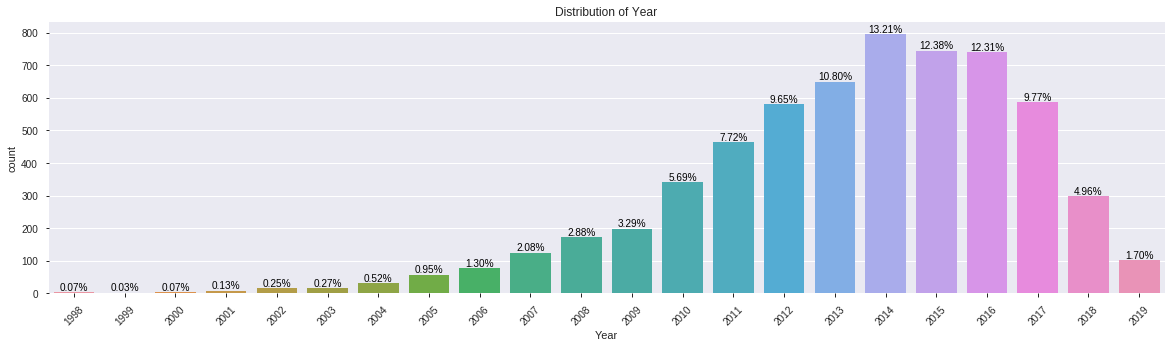

In [32]:
# Check the Year make distribution of the Training data
count_plot(train,'Year',20,5,rotate = 'Y', order = 'N')

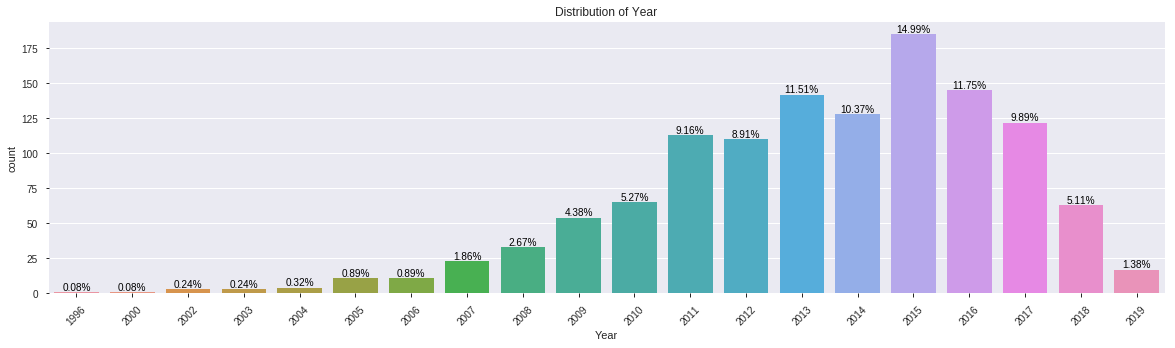

In [33]:
# Check the Year make distribution of the Test data
count_plot(test,'Year',20,5,rotate = 'Y', order = 'N')

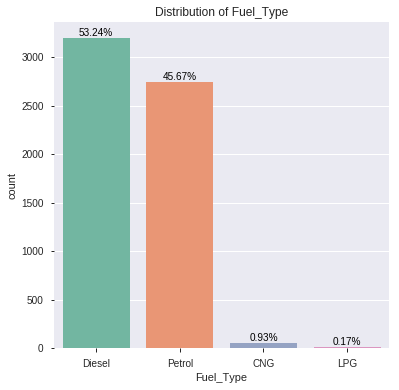

In [34]:
# Check the Fule type distribution of the Training data
count_plot(train,'Fuel_Type',6,6)

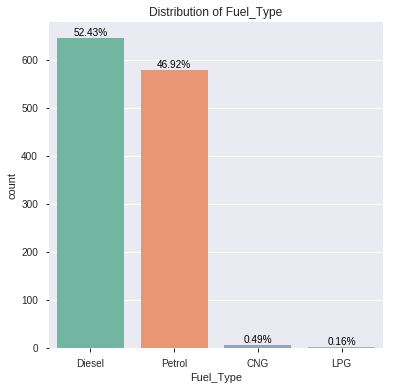

In [35]:
# Check the Fule type distribution of the Test data
count_plot(test,'Fuel_Type',6,6)

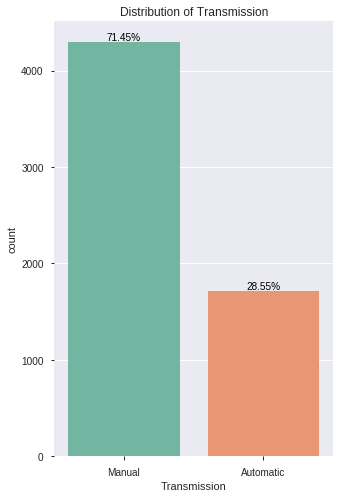

In [36]:
# Check the Transmission distribution of the Training data
count_plot(train,'Transmission',5,8)

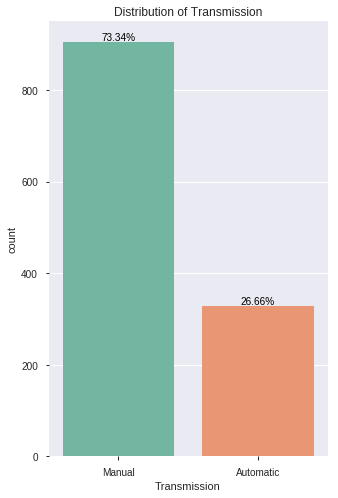

In [37]:
# Check the Transmission distribution of the Test data
count_plot(test,'Transmission',5,8)

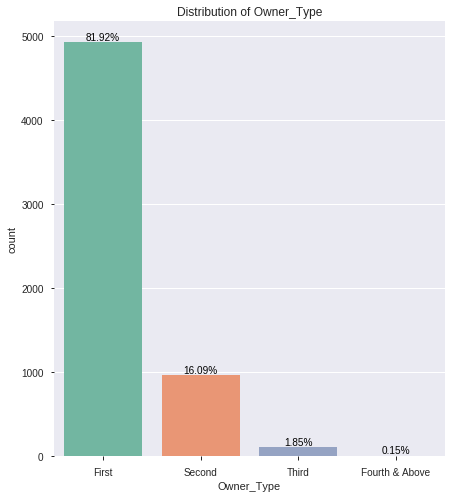

In [38]:
# Check the Transmission distribution of the Training data
count_plot(train,'Owner_Type',7,8)

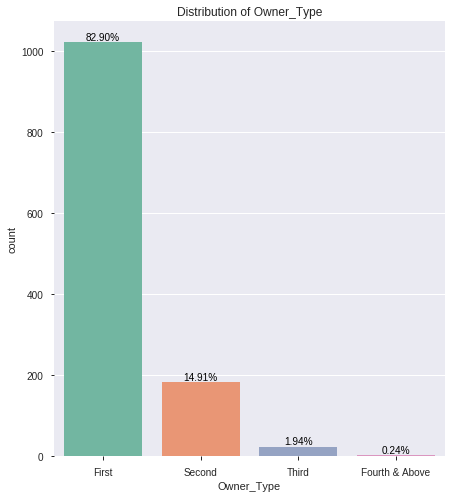

In [39]:
# Check the Transmission distribution of the Test data
count_plot(test,'Owner_Type',7,8)

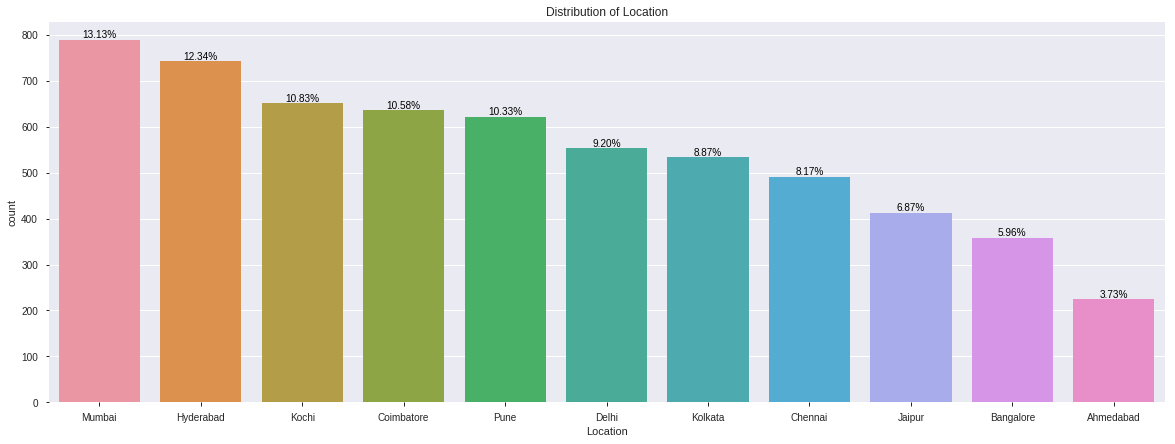

In [40]:
# Check the Transmission distribution of the Training data
count_plot(train,'Location',20,7)

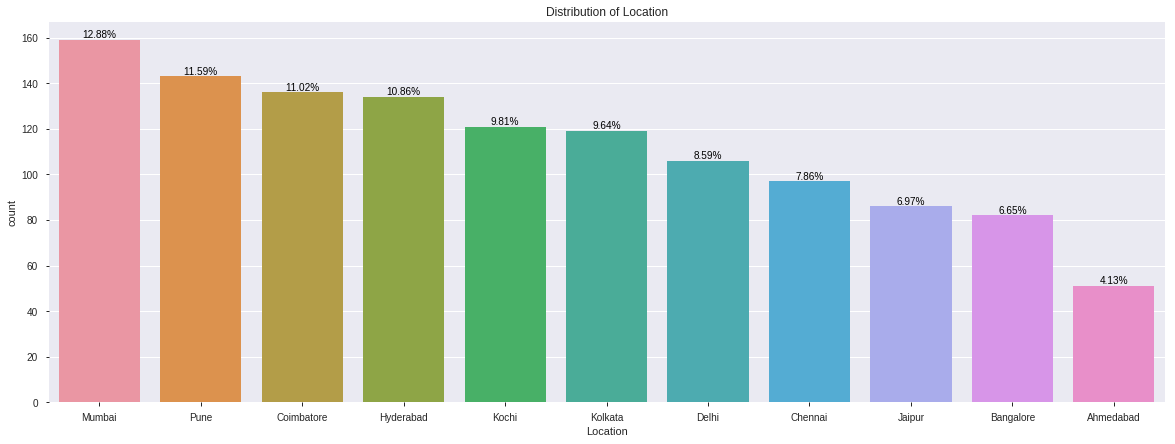

In [41]:
# Check the Transmission distribution of the Test data
count_plot(test,'Location',20,7)

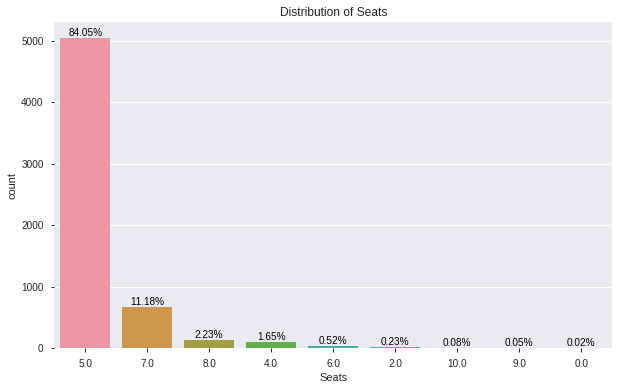

In [42]:
# Check the Transmission distribution of the Train data
count_plot(train,'Seats',10,6)

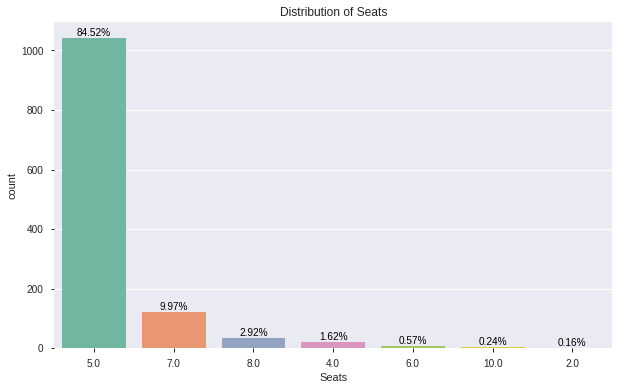

In [43]:
# Check the Transmission distribution of the Test data
count_plot(test,'Seats',10,6)

We observed that there are no vehicles with **0** or **9** seats in the test set. Lets check cars with **0,2,9 and 10** seats in the training data and adjust the training data to align with the test set.

In [44]:
train[train.Seats.isin([0,2,9,10])]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Full_name,brand
134,mercedesbenz slc,Kolkata,2017,13372,Petrol,Automatic,First,19.00,2996.00,362.07,2.00,9504000.00,54.00,mercedesbenz slc 43 amg,mercedesbenz
557,audi tt,Delhi,2013,12100,Petrol,Automatic,First,9.90,1984.00,207.80,2.00,6400724.92,29.50,audi tt 20 tfsi,audi
693,mercedesbenz slkclass,Coimbatore,2016,22732,Petrol,Automatic,First,18.10,3498.00,306.00,2.00,6528088.27,55.54,mercedesbenz slkclass slk 350,mercedesbenz
798,mercedesbenz slkclass,Bangalore,2015,10000,Petrol,Automatic,First,18.10,3498.00,306.00,2.00,6528088.27,55.00,mercedesbenz slkclass slk 350,mercedesbenz
814,toyota qualis,Pune,2004,77757,Diesel,Manual,Second,13.10,2446.00,75.00,10.00,2461357.63,3.50,toyota qualis fs b2,toyota
917,tata sumo,Mumbai,2013,20000,Diesel,Manual,First,14.07,1978.00,83.10,10.00,1008787.72,5.25,tata sumo dx,tata
926,porsche cayman,Hyderabad,2010,10000,Petrol,Manual,First,9.00,3436.00,331.29,2.00,13600000.00,40.00,porsche cayman s,porsche
1078,porsche boxster,Kolkata,2015,10512,Petrol,Automatic,First,8.60,2706.00,265.00,2.00,13600000.00,64.00,porsche boxster s tiptronic,porsche
1288,audi tt,Kochi,2014,14262,Petrol,Automatic,First,9.90,1984.00,207.80,2.00,6400724.92,27.35,audi tt 20 tfsi,audi
1347,mahindra scorpio,Bangalore,2007,74112,Diesel,Manual,First,12.05,2179.00,120.00,9.00,1583337.61,4.10,mahindra scorpio lx bs iv,mahindra


The data seems legit except for only some records with 0 and 9 seats. Lets fill the 0 audi a4 seat with 5 seats and the other vehicle having 9 seats with 10 seats.



In [45]:
train.loc[3999,'Seats'] = 5

train.Seats[train.Seats == 9] = 10

Lets checkout the power, Mileage and Engine distribution across the Training and the test set

In [46]:
# Define function for the next set of graph distributions.
def dist_plot(data, col, bins, color, figx, figy, kde = True):
    plt.figure(figsize=(figx,figy))
    sns.distplot(data[col].values, bins=bins, color=color, kde_kws={"shade": True}, label="Low", kde=kde)
    plt.title("Histogram of %s Distribution"%col)
    plt.xlabel('%s'%col, fontsize=12)
    plt.ylabel('Vehicle Count', fontsize=12)
    plt.show();

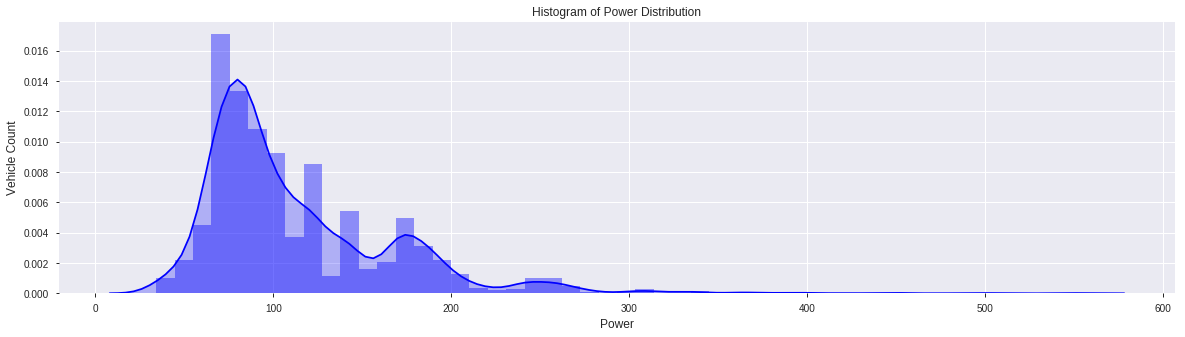

In [47]:
# Check the Power distribution of the Train data
dist_plot(train,'Power', 50, 'blue', 20, 5)

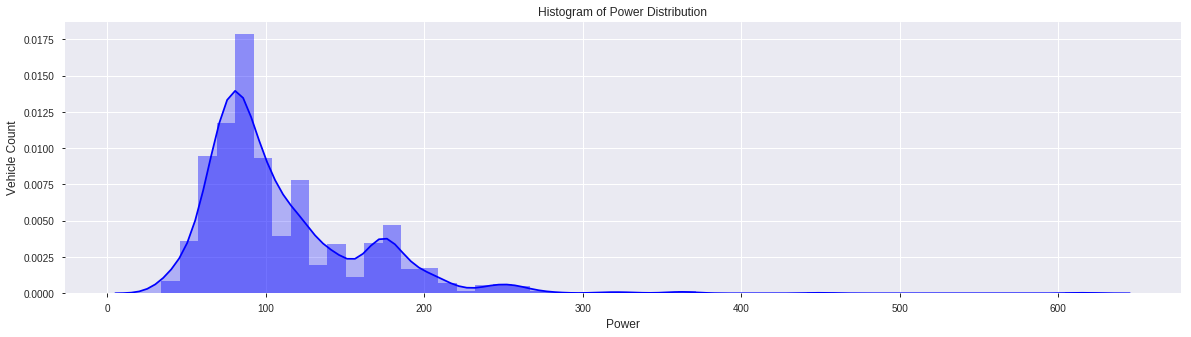

In [48]:
# Check the Power distribution of the Test data
dist_plot(test,'Power', 50, 'blue', 20, 5)

Power Data distribution is similar. Lets check the Engine distribution

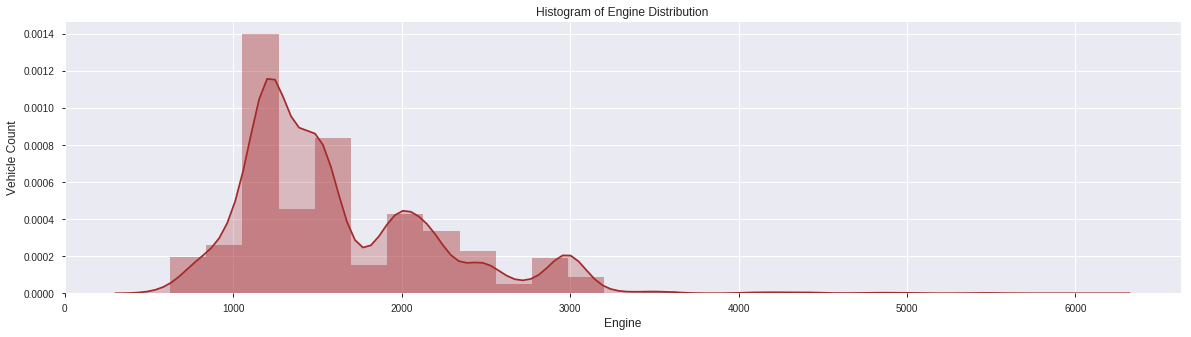

In [49]:
# Check the Power distribution of the Train data
dist_plot(train,'Engine', 25, 'brown', 20, 5)

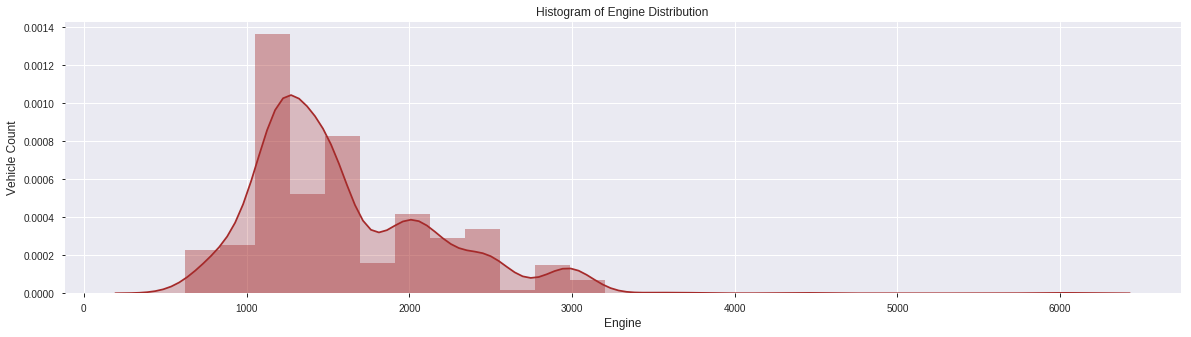

In [50]:
# Check the Power distribution of the Test data
dist_plot(test,'Engine', 25, 'brown', 20, 5)

Engine Data seems to be consistent across both the sets. Lets check the Mileage distribution

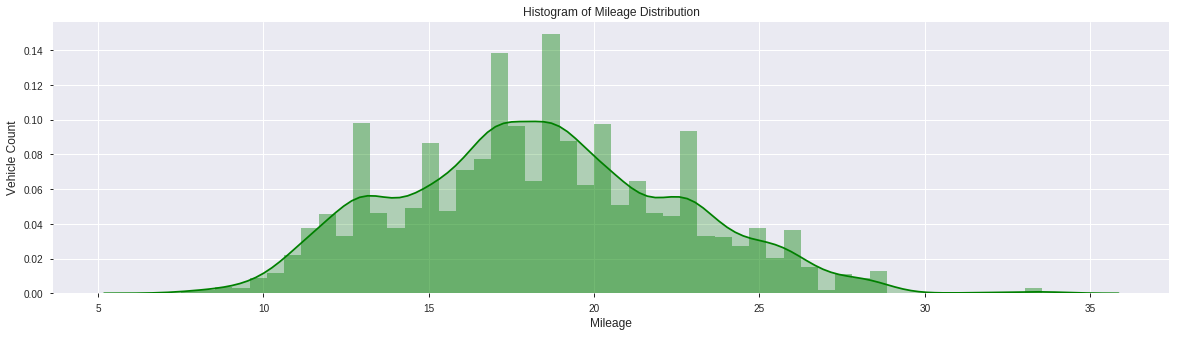

In [51]:
# Check the Power distribution of the Train data
dist_plot(train,'Mileage', 50, 'green', 20, 5)

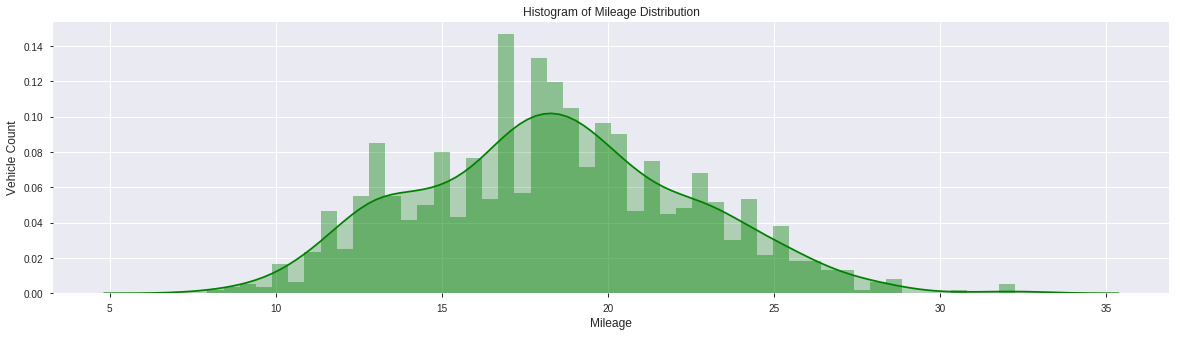

In [52]:
# Check the Power distribution of the Test data
dist_plot(test,'Mileage', 50, 'green', 20, 5)

Mileage records are also similarly distributed in both the sets. Lets check Kilometers_Driven data now

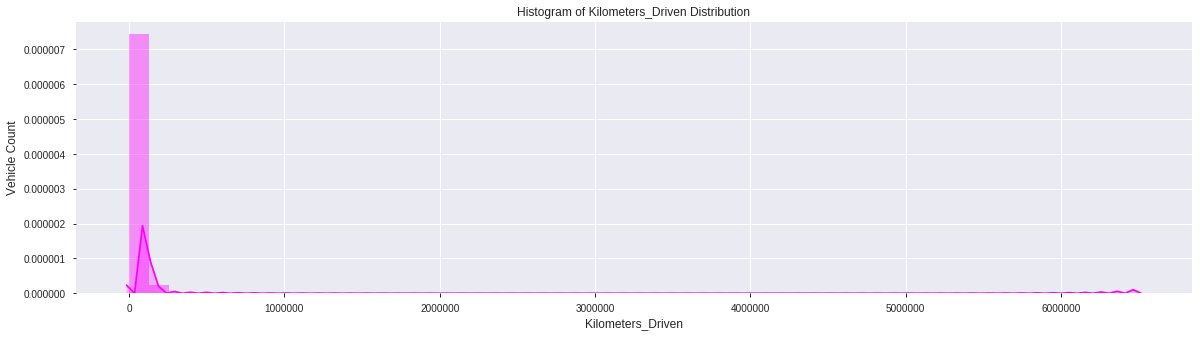

In [53]:
# Check the Power distribution of the Training data
dist_plot(train,'Kilometers_Driven', 50, 'magenta', 20, 5)

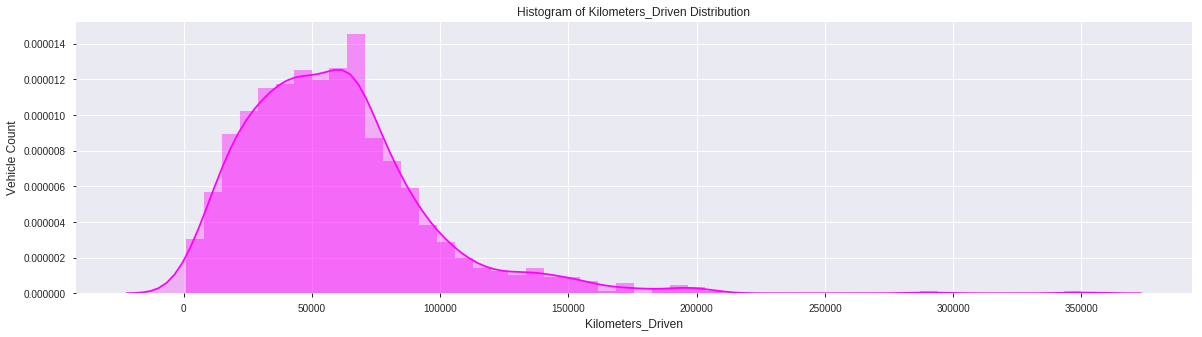

In [54]:
# Check the Power distribution of the Test data
dist_plot(test,'Kilometers_Driven', 50, 'magenta', 20, 5)

Here we can see that the data in **training** set is **highly skewed** which is a pointer to outliers. Lets check those black birds

In [55]:
col = 'Kilometers_Driven'
from scipy import stats
outliers = train[col][(np.abs(stats.zscore(train[col])) > 3)]
outliers

340      775000
358      620000
1860     720000
2328    6500000
2823     480000
3092     480000
4491     445000
Name: Kilometers_Driven, dtype: int64

Let's check the same records for these outlier values

In [56]:
train[train.Kilometers_Driven.isin(outliers)]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Full_name,brand
340,skoda octavia,Kolkata,2013,775000,Diesel,Automatic,First,19.30,1968.00,141.00,5.00,2837000.00,7.50,skoda octavia ambition plus 20 tdi at,skoda
358,hyundai i10,Chennai,2009,620000,Petrol,Manual,First,20.36,1197.00,78.90,5.00,1079571.38,2.70,hyundai i10 magna 12,hyundai
1860,volkswagen vento,Chennai,2013,720000,Diesel,Manual,First,20.54,1598.00,103.60,5.00,1317111.11,5.90,volkswagen vento diesel highline,volkswagen
2328,bmw x5,Chennai,2017,6500000,Diesel,Automatic,First,15.97,2993.00,258.00,5.00,6386717.30,65.00,bmw x5 xdrive 30d m sport,bmw
2823,volkswagen jetta,Chennai,2015,480000,Diesel,Automatic,First,16.96,1968.00,138.03,5.00,1126701.34,13.00,volkswagen jetta 20l tdi highline at,volkswagen
3092,honda city,Kolkata,2015,480000,Petrol,Manual,First,17.40,1497.00,117.30,5.00,1416478.26,5.00,honda city i vtec sv,honda
4491,hyundai i20,Bangalore,2013,445000,Petrol,Manual,First,18.50,1197.00,82.90,5.00,999500.00,4.45,hyundai i20 magna optional 12,hyundai


No other ambiguity found except the KM driven values. Let's remove these and check the distribution

In [57]:
train = train[~train.Kilometers_Driven.isin(outliers)]

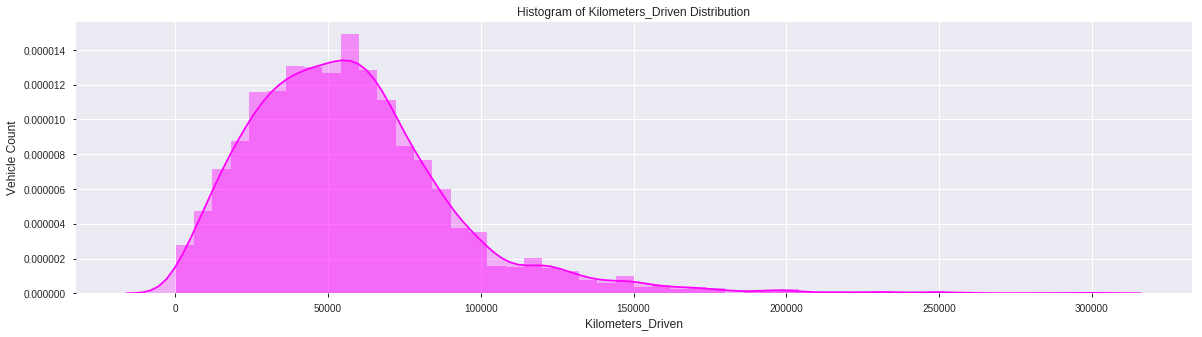

In [58]:
dist_plot(train,'Kilometers_Driven', 50, 'magenta', 20, 5, kde = True)

Now the Kilometers_Driven distribution of the training set looks more meaningful and in-sync with the test set

Let's move on and create new features from the existing ones.

In [59]:
# Record the age of the car
import datetime
train['Age'] = datetime.datetime.now().year - train['Year']
test['Age'] = datetime.datetime.now().year - test['Year']

In [60]:
# Record the number of words in the Full_name of the car
train['Name_length'] = train.Full_name.apply(lambda x: len(str(x).split(' ')))
test['Name_length'] = test.Full_name.apply(lambda x: len(str(x).split(' ')))

In [61]:
# Define categorical features
categorical_features = ['Location','Fuel_Type','Transmission','Owner_Type','Seats']

# Define function for dummy operation
def get_dummies(dataframe,feature_name):
  dummy = pd.get_dummies(dataframe[feature_name], prefix=feature_name)
  dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
  return pd.concat([dataframe,dummy], axis = 1)

# Dummify categorical features
for i in categorical_features:
    train = get_dummies(train, i)
    test = get_dummies(test, i)


In [62]:
# Define function to aggregate metrics for different features
def aggregate_features(data):   
    
    aggregate_dict = {  'Age' : ['count'],
                        'Mileage' : ['sum','max','min','mean','std','median','skew'],
                        'Power' : ['sum','max','min','mean','std','median','skew'],
                        'Engine' : ['sum','max','min','mean','std','median','skew']}
    
    data_agg = data.groupby(['Name']).agg(aggregate_dict)
    data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns.values]
    data_agg.reset_index(inplace=True)    
    data_agg = pd.merge(data, data_agg, on='Name', how='left')    
    return data_agg

In [63]:
# Create aggregated features
train = aggregate_features(train)
test = aggregate_features(test)

Let's check the missing values after creating the aggregated features

In [64]:
missing_values_table(train)

Your selected dataframe has 62 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Mileage_skew,61,1.00
Power_skew,61,1.00
Engine_skew,61,1.00
Mileage_std,23,0.40
Power_std,23,0.40
Engine_std,23,0.40


In [65]:
missing_values_table(test)

Your selected dataframe has 61 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Mileage_skew,75,6.10
Power_skew,75,6.10
Engine_skew,75,6.10
Mileage_std,39,3.20
Power_std,39,3.20
Engine_std,39,3.20


Very less number of values are missing. Let's fill these values with the mean of the respective column

In [66]:
train.Mileage_skew = train.Mileage_skew.fillna(train.Mileage_skew.mean())
train.Power_skew = train.Power_skew.fillna(train.Power_skew.mean())
train.Engine_skew = train.Engine_skew.fillna(train.Engine_skew.mean())
train.Mileage_std = train.Mileage_std.fillna(train.Mileage_std.mean())
train.Power_std = train.Power_std.fillna(train.Power_std.mean())
train.Engine_std = train.Engine_std.fillna(train.Engine_std.mean())

test.Mileage_skew = test.Mileage_skew.fillna(test.Mileage_skew.mean())
test.Power_skew = test.Power_skew.fillna(test.Power_skew.mean())
test.Engine_skew = test.Engine_skew.fillna(test.Engine_skew.mean())
test.Mileage_std = test.Mileage_std.fillna(test.Mileage_std.mean())
test.Power_std = test.Power_std.fillna(test.Power_std.mean())
test.Engine_std = test.Engine_std.fillna(test.Engine_std.mean())

Let's move ahead and create aggregated vectors for the vehicle name in each record

In [67]:
import gensim
import multiprocessing
cores = multiprocessing.cpu_count()

# Define function to add/aggregate embeddings of single token text
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [68]:
total_names = pd.concat([train.Full_name, test.Full_name], ignore_index=True)
tokens = total_names.apply(lambda x: x.split()) # tokenizing text
train_tokens = train.Full_name.apply(lambda x: x.split()) # tokenizing text
test_tokens = test.Full_name.apply(lambda x: x.split()) # tokenizing text
tokens_size = len(tokens)
train_tokens_size = len(train_tokens)
test_tokens_size = len(test_tokens)

In [69]:
model_w2v = gensim.models.Word2Vec(
            tokens,
            size=200, # desired no. of features/independent variables
            window=2, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0, # off heirarchichal softmax
            negative = 1, # for negative sampling
            workers= cores-1, # no.of cores
#             sample=.1,
            alpha=0.009, 
            min_alpha=0.0009,
#             seed=0,
#             hashfxn=hash
) 

model_w2v.train(tokens,
                total_examples= tokens_size,
                epochs=40)

(915393, 1383840)

In [70]:
wordvec_train_array = np.zeros((train_tokens_size, 200)) 
wordvec_test_array = np.zeros((test_tokens_size, 200))

for i in range(train_tokens_size):
    wordvec_train_array[i,:] = word_vector(train_tokens[i], 200)
wordvec_train_df = pd.DataFrame(wordvec_train_array)

for i in range(test_tokens_size):
    wordvec_test_array[i,:] = word_vector(test_tokens[i], 200)
wordvec_test_df = pd.DataFrame(wordvec_test_array)

In [71]:
wordvec_train_df.shape, wordvec_test_df.shape

((6004, 200), (1234, 200))

In [72]:
model_w2v.wv.most_similar(positive="hyundai")

[('asta', 0.9302453994750977),
 ('crdi', 0.9271082878112793),
 ('i10', 0.9156997203826904),
 ('magna', 0.9148060083389282),
 ('i20', 0.9141782522201538),
 ('kappa', 0.9130206108093262),
 ('sportz', 0.9088948369026184),
 ('xcent', 0.9081591367721558),
 ('base', 0.9038722515106201),
 ('grand', 0.9003891348838806)]

Word2Vec vectors are giving appropriate results. That's nice!!

In [73]:
# Define function for multiple aggregation on a dataframe rows
def agg_df(df):
    return pd.DataFrame(
                        {'Name_sum':df.sum(axis=1),
                         'Name_mean':df.mean(axis=1),
                         'Name_std':df.std(axis=1),
                         'Name_max':df.max(axis=1),
                         'Name_min':df.min(axis=1),
                         'Name_median':df.median(axis=1),
                         'Name_skew':df.skew(axis=1)
                        }
                       )

In [74]:
# Add aggregated features on the Name word2vec vctors.
train = pd.concat([train, agg_df(wordvec_train_df)], axis=1) 
test = pd.concat([test, agg_df(wordvec_test_df)], axis=1) 

Let's take a look at the train dataset after feature aggregation

In [75]:
train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Full_name,brand,Age,Name_length,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Seats_4.0,Seats_5.0,Seats_6.0,Seats_7.0,Seats_8.0,Seats_10.0,Age_count,Mileage_sum,Mileage_max,Mileage_min,Mileage_mean,Mileage_std,Mileage_median,Mileage_skew,Power_sum,Power_max,Power_min,Power_mean,Power_std,Power_median,Power_skew,Engine_sum,Engine_max,Engine_min,Engine_mean,Engine_std,Engine_median,Engine_skew,Name_sum,Name_mean,Name_std,Name_max,Name_min,Name_median,Name_skew
0,maruti wagon,Mumbai,2010,72000,CNG,Manual,First,26.60,998.00,58.16,5.00,548657.14,1.75,maruti wagon r lxi cng,maruti,9,5,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,154,3228.94,33.54,12.00,20.97,3.84,20.51,1.11,10169.35,81.80,57.50,66.03,4.51,67.04,0.88,156209.00,1197.00,998.00,1014.34,42.77,998.00,3.23,1.99,0.01,0.18,0.50,-0.58,-0.00,0.07
1,hyundai creta,Pune,2015,41000,Diesel,Manual,First,19.67,1582.00,126.20,5.00,1640058.82,12.50,hyundai creta 16 crdi sx option,hyundai,4,6,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,93,1633.01,22.10,13.00,17.56,2.57,17.01,-0.27,11330.30,126.20,88.70,121.83,9.06,126.20,-3.20,146343.00,1591.00,1396.00,1573.58,47.09,1582.00,-3.55,0.88,0.00,0.18,0.48,-0.53,0.01,-0.04
2,honda jazz,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.00,88.70,5.00,861000.00,4.50,honda jazz v,honda,8,3,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,58,1187.30,27.30,16.00,20.47,3.98,18.70,1.07,5292.35,98.60,88.70,91.25,4.21,88.70,1.20,73722.00,1498.00,1198.00,1271.07,129.12,1199.00,1.24,-3.49,-0.02,0.19,0.50,-0.56,-0.01,-0.01
3,maruti ertiga,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.00,88.76,7.00,1152615.38,6.00,maruti ertiga vdi,maruti,7,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,75,1569.27,25.47,16.02,20.92,3.12,20.77,-0.09,6700.46,103.00,80.46,89.34,3.23,88.76,0.38,96064.00,1462.00,1248.00,1280.85,57.67,1248.00,1.31,2.37,0.01,0.17,0.47,-0.49,0.01,-0.01
4,audi a4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.00,140.80,5.00,5251000.00,17.74,audi a4 new 20 tdi multitronic,audi,6,6,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,78,1279.27,18.25,10.50,16.40,1.41,16.55,-2.38,12763.48,241.40,132.00,163.63,24.31,163.42,1.54,157628.00,3197.00,1395.00,2020.87,272.36,1968.00,3.11,-2.88,-0.01,0.18,0.44,-0.48,-0.02,0.08


Lets have a look at the correlation between various relevant features through Heatmap

[MLENS] backend: threading


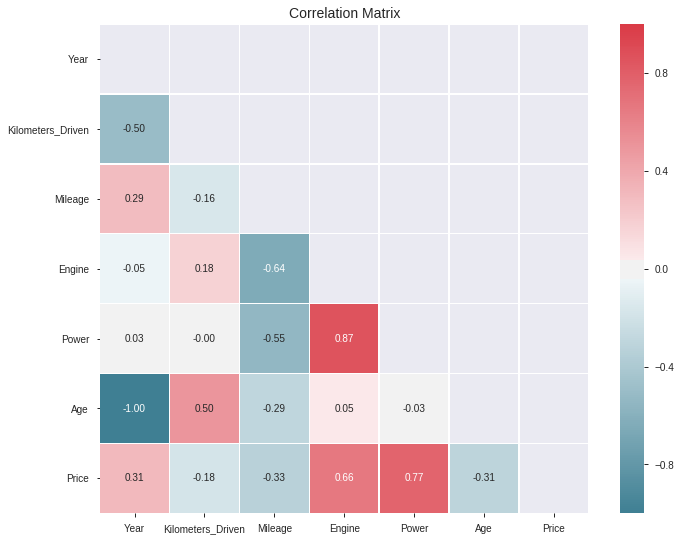

In [76]:
features = ['Year','Kilometers_Driven','Mileage','Engine','Power','Age','Price']

# Through CORRMAT
from mlens.visualization import corrmat
corrmat(train[features].corr(), inflate=False)
plt.show();

#### Here we can observe below things

* Power and Engine are highly correlated.
* Price has good correlation with Engine and Power.
* We can see that Price is negatively correlated with Mileage, KMs_Driven and Age which is legit

So, let's see actual distribution as per the above correlation.

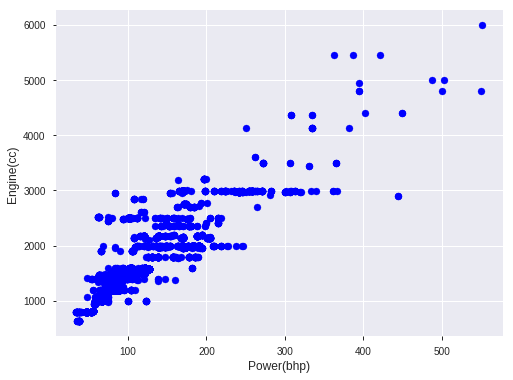

In [77]:
# Engine and Power 
plt.figure(figsize=(8,6))
plt.scatter(train.Power, train.Engine, c='blue')
plt.xlabel('Power(bhp)', fontsize=12)
plt.ylabel('Engine(cc)', fontsize=12)
plt.show();

Both the features **Engine** and **Power** are almost **linearly** corelated.

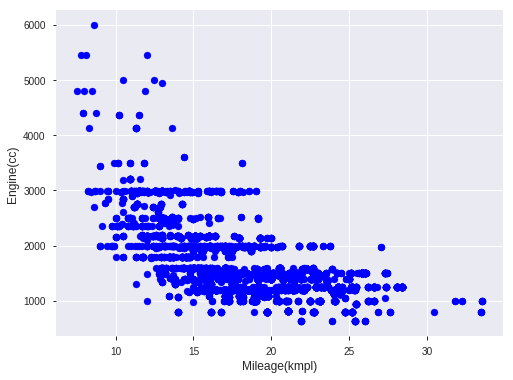

In [78]:
# Engine and Mileage 
plt.figure(figsize=(8,6))
plt.scatter(train.Mileage, train.Engine, c='blue')
plt.xlabel('Mileage(kmpl)', fontsize=12)
plt.ylabel('Engine(cc)', fontsize=12)
plt.show();

That's a very legit correlation between **Engine** and **Mileage** i.e. as the Engine capacity increases its mileage decreases

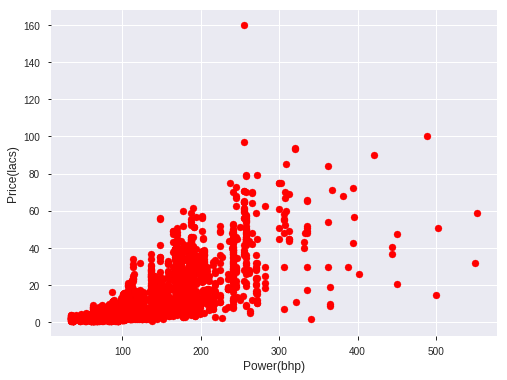

In [79]:
# Power and Price
plt.figure(figsize=(8,6))
plt.scatter(train.Power, train.Price, c='red')
plt.xlabel('Power(bhp)', fontsize=12)
plt.ylabel('Price(lacs)', fontsize=12)
plt.show();

Of course, the increase in **Power** comes with the increase in vehicle **price**. But the price factor seems to have **plateaued** after a certain Power range of 250 bhp

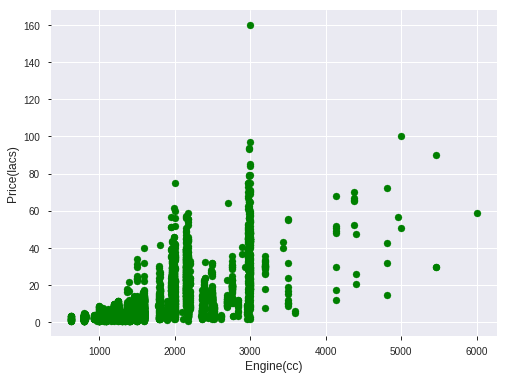

In [80]:
# Engine and Price
plt.figure(figsize=(8,6))
plt.scatter(train.Engine, train.Price, c='green')
plt.xlabel('Engine(cc)', fontsize=12)
plt.ylabel('Price(lacs)', fontsize=12)
plt.show();

**Engine** also shows similar pattern as of Power when shocased with the **Price**.

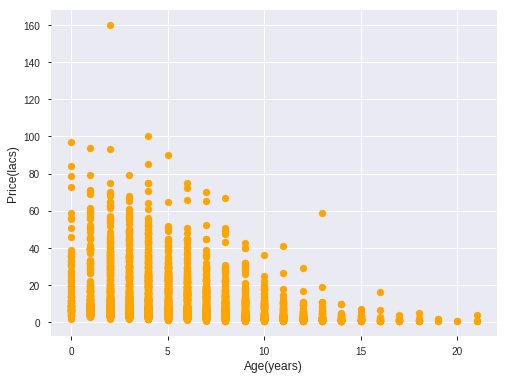

In [81]:
# Age and Price
plt.figure(figsize=(8,6))
plt.scatter(train.Age, train.Price, c='orange')
plt.xlabel('Age(years)', fontsize=12)
plt.ylabel('Price(lacs)', fontsize=12)
plt.show();

That's right!! Aeging vehicles sells for lesser price as compared to the younger vehicles.

In [82]:
# Take backup before dropping some features
train_backup = train.copy() 
test_backup = test.copy() 

# Drop irrelevant features
drop_features = ['Location','Fuel_Type','Transmission','Owner_Type','Seats','Full_name','Name','brand']
backup_train = train.drop(drop_features, axis=1, inplace=True)
backup_test = test.drop(drop_features, axis=1, inplace=True)

In [83]:
# Assign values to variables for training and testing

X_train = train.drop(labels=['Price'], axis=1) # Assign all features except Price to X
y_train = np.log1p(train['Price'].values) # Convert Price to log scale
X_test = test.copy()

In [84]:
# Scale the train and test set before feeding to the model

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test),columns = X_test.columns)

### Model training and prediction

We will use **LGB** because it generally **trains** much **faster** as compared to **XGBoost** and mostly gives **equivalent** or **better results**.

In [85]:
train_X = X_train.copy()
train_y = y_train.copy()
test_X = X_test.copy()

# Define LGBM function
def runLGB(train_X, train_y, val_X=None, val_y=None, test_X=None, dep=-1, seed=0, data_leaf=5):
    params = {}
    params["objective"] = "regression"
    params['metric'] = 'l2_root'
    params['boosting'] = 'gbdt'
#     params["max_depth"] = dep
#     params["num_leaves"] = 39
#     params["min_data_in_leaf"] = data_leaf
    params["learning_rate"] = 0.009
    params["bagging_fraction"] = 0.75
    params["feature_fraction"] = 0.75
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed
#     params["lambda_l2"] = 5
#     params["lambda_l1"] = 5
    params["silent"] = True
    params["random_state"] = seed,
    num_rounds = 3000
    
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if val_y is not None:
        lgtest = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=50, verbose_eval=100)
    else:
        lgtest = lgb.DMatrix(val_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
  
    loss = 0
    
    if val_y is not None:
        loss = sqrt(mean_squared_log_error(np.expm1(val_y), np.expm1(pred_val_y)))
        return model, loss, pred_test_y
    else:
        return model, loss, pred_test_y

## K-FOLD train

cv_scores = [] # array for keeping cv-scores for each fold.
pred_test_full = 0 # array to keep predictions of each fold.
pred_train = np.zeros(train_X.shape[0])
n_fold = 10
print(f"Building model over {n_fold} folds\n")
kf = KFold(n_splits=n_fold, shuffle=True, random_state=4)

feature_importance = pd.DataFrame()
for fold_n, (dev_index, val_index) in enumerate(kf.split(train_X, train_y)):    
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    model, loss, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, dep=8, seed=0)
      
    pred_test_full += pred_t
    print(f"\n>>>>RMSLE for fold {fold_n+1} is: {loss}<<<<\n")
    cv_scores.append(loss)
    
    # feature importance aggregation over n folds
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_train.columns
    fold_importance["importance"] = model.feature_importance()
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Building model over 10 folds

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.348967
[200]	valid_0's rmse: 0.233257
[300]	valid_0's rmse: 0.199852
[400]	valid_0's rmse: 0.190577
[500]	valid_0's rmse: 0.187707
[600]	valid_0's rmse: 0.186182
[700]	valid_0's rmse: 0.185932
[800]	valid_0's rmse: 0.185759
Early stopping, best iteration is:
[788]	valid_0's rmse: 0.185636

>>>>RMSLE for fold 1 is: 0.18563573339087477<<<<

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.389565
[200]	valid_0's rmse: 0.240081
[300]	valid_0's rmse: 0.184333
[400]	valid_0's rmse: 0.161744
[500]	valid_0's rmse: 0.151157
[600]	valid_0's rmse: 0.145853
[700]	valid_0's rmse: 0.142782
[800]	valid_0's rmse: 0.140811
[900]	valid_0's rmse: 0.139763
[1000]	valid_0's rmse: 0.139
[1100]	valid_0's rmse: 0.138314
[1200]	valid_0's rmse: 0.137615
[1300]	valid_0's rmse: 0.137381
[1400]	valid_0's rmse: 0.137175
[1500]	valid_0's rmse: 0.136963
[1600]	valid_

In [86]:
print(f"Mean RMSLE score over folds is: {np.mean(cv_scores)}")

# Aggregate mean prediction over 10 folds.
pred_test_full /= n_fold
pred_test_final = np.expm1(pred_test_full)

Mean RMSLE score over folds is: 0.13210865430970348


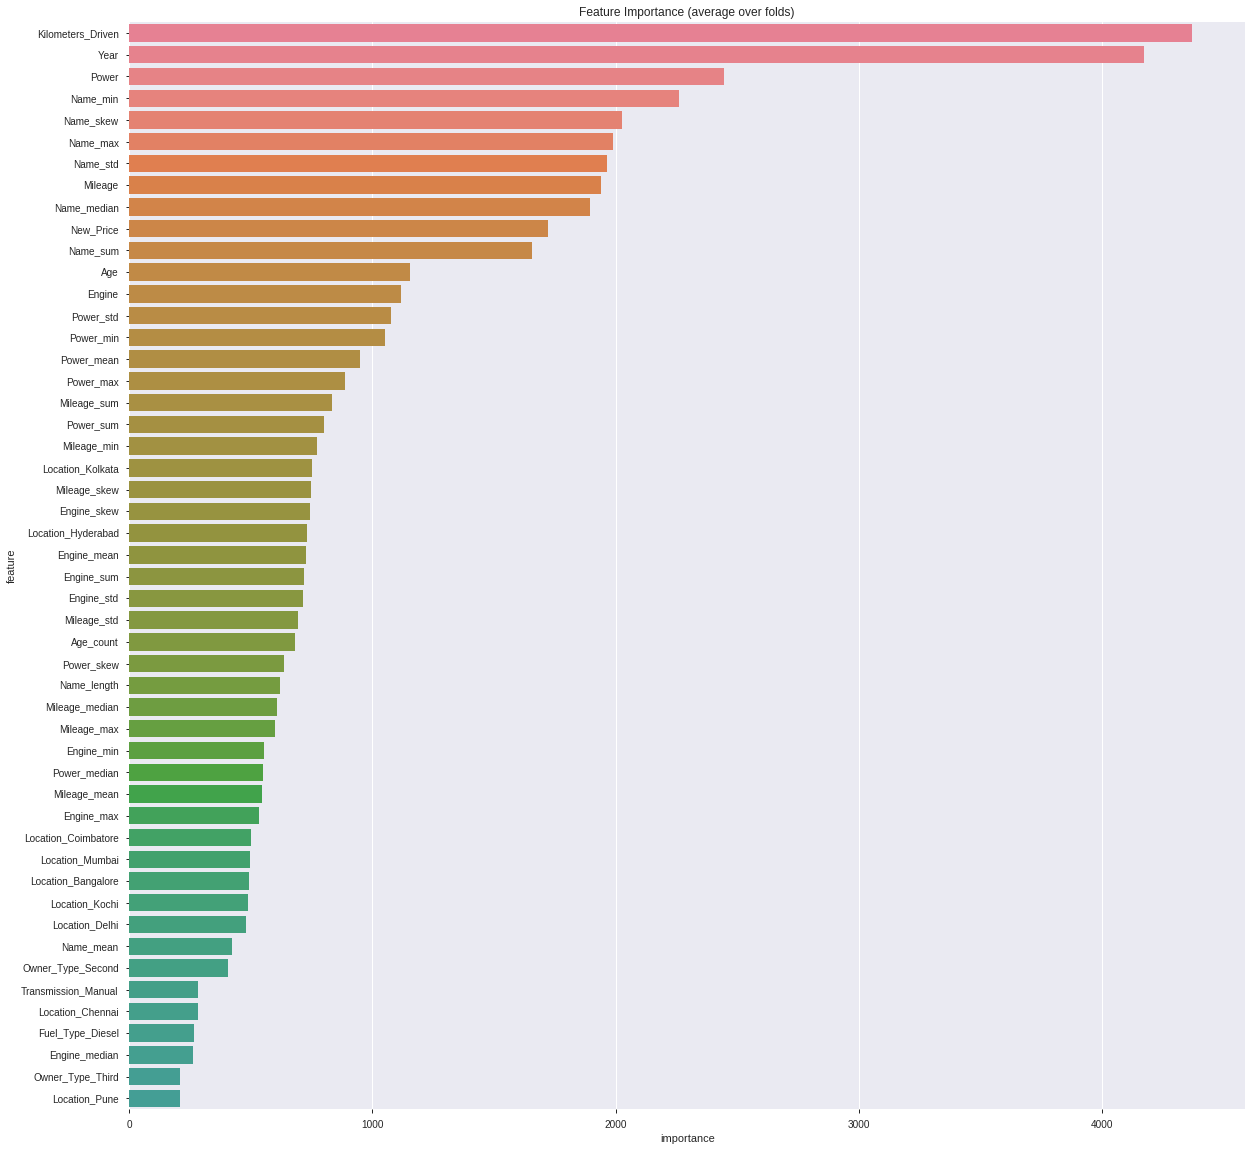

In [87]:
# Plot feature importance mean aggregated over 10 folds
plt.figure(figsize=(20, 20));
feature_importance = pd.DataFrame(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index())[:50]
sns.barplot(x="importance", y="feature", data=feature_importance);
plt.title('Feature Importance (average over folds)');

In [88]:
# Create submission file.
Predict_submission = pd.DataFrame(data=pred_test_final, columns=['Price'])
writer = pd.ExcelWriter('Output.xlsx', engine='xlsxwriter')
Predict_submission.to_excel(writer,sheet_name='Sheet1', index=False)
writer.save()

So this was it... This kernel is open to suggestions for improvement over this score through any means other than stacking and hyper-parameter tuning. If you have such idea ... please share and we will try to improve on current score.

Thanks for reading guys !!